# Clustering

In [94]:
# V1.0
# Dataset: https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data

## Vorbereitung

In [95]:
import warnings # Warnungen entfernen (Warnungen sind Hinweise und keine Fehler) -> bessere Übersicht des Codes
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd

import random

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import scipy.cluster.hierarchy as shc

import numpy as np
import seaborn as sns
sns.set(font_scale=1.35)
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler, Normalizer
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import InterclusterDistance

%matplotlib inline

### Dataset einlesen

In [96]:
df = pd.read_csv("penguins_size.csv")
df_with_labels = df
df = df.drop(columns=['species']) # Labels löschen, da diese für ein Clustering nicht verwendet werden (siehe Aufgabenstellung)
df.head(5)

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [97]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   island             344 non-null    object 
 1   culmen_length_mm   342 non-null    float64
 2   culmen_depth_mm    342 non-null    float64
 3   flipper_length_mm  342 non-null    float64
 4   body_mass_g        342 non-null    float64
 5   sex                334 non-null    object 
dtypes: float64(4), object(2)
memory usage: 16.2+ KB


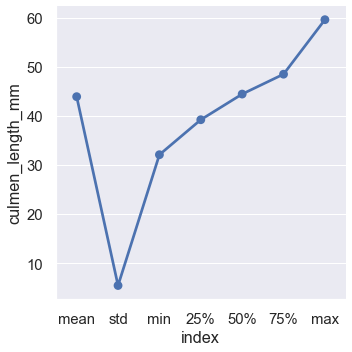

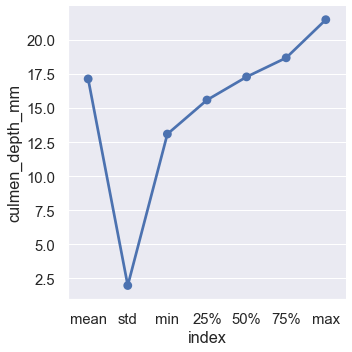

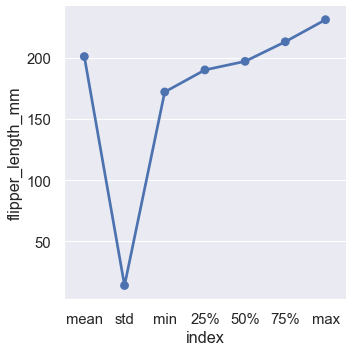

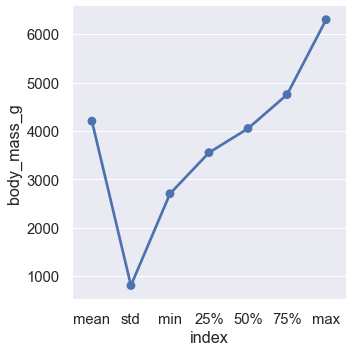

In [99]:
total_columns = df.columns
num_col = df._get_numeric_data().columns
cat_col = list(set(total_columns)-set(num_col))
describe_num_df = df.describe(include=['int64','float64'])
describe_num_df.reset_index(inplace=True)
describe_num_df = describe_num_df[describe_num_df['index'] != 'count']

for i in num_col:
    if i in ['index']:
        continue
    sns.factorplot(x='index', y=i, data=describe_num_df)
plt.show()

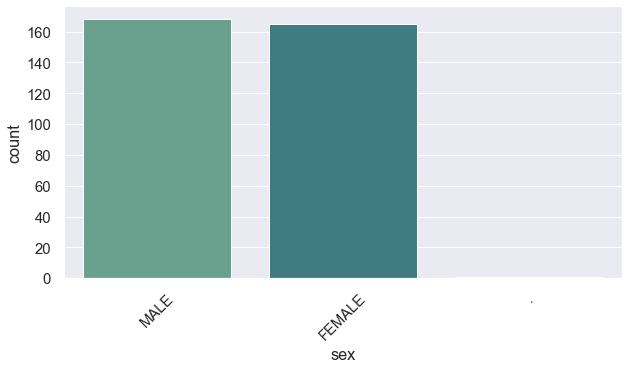

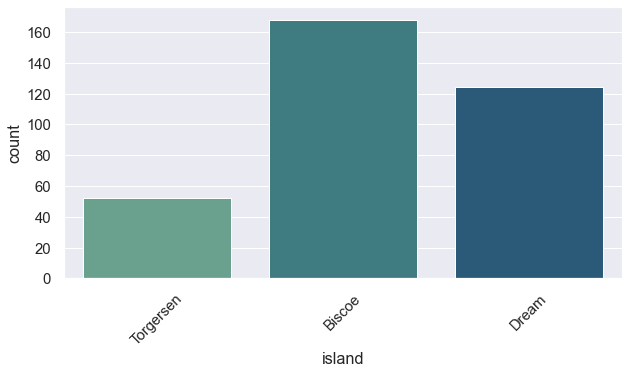

In [100]:
for i in cat_col:
    if i in ['source']:
        continue
    plt.figure(figsize=(10, 5))
    chart = sns.countplot(
    data=df,
    x=i,
    palette='crest'
    )
    
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.show()

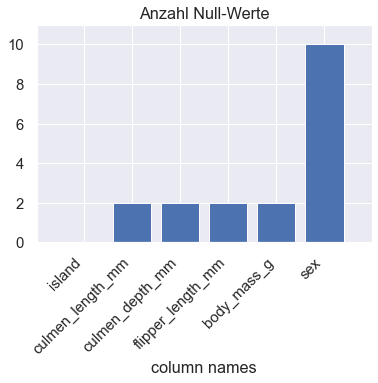

In [101]:
null_df = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')

plt.bar(null_df.index, null_df['count'])
plt.xticks(null_df.index, null_df.index, rotation=45,
horizontalalignment='right')
plt.xlabel('column names')
plt.margins(0.1)
plt.title("Anzahl Null-Werte")
plt.show()

### Data Cleaning

In [102]:
df = df.dropna()

#### Wert der Spalten überprüfen

In [103]:
for column in df:
    print(column, ":", "\n", df[column].unique())
    print("------------------------")

island : 
 ['Torgersen' 'Biscoe' 'Dream']
------------------------
culmen_length_mm : 
 [39.1 39.5 40.3 36.7 39.3 38.9 39.2 41.1 38.6 34.6 36.6 38.7 42.5 34.4
 46.  37.8 37.7 35.9 38.2 38.8 35.3 40.6 40.5 37.9 37.2 40.9 36.4 42.2
 37.6 39.8 36.5 40.8 36.  44.1 37.  39.6 42.3 40.1 35.  42.  34.5 41.4
 39.  35.7 41.3 41.6 35.5 41.8 33.5 39.7 45.8 42.8 36.2 42.1 42.9 35.1
 37.3 36.3 36.9 38.3 34.  38.1 33.1 43.2 41.  45.6 42.7 40.2 35.2 41.5
 38.5 43.1 36.8 37.5 35.6 32.1 40.7 46.5 50.  51.3 45.4 52.7 45.2 46.1
 46.6 51.7 47.  52.  45.9 50.5 50.3 58.  46.4 49.2 42.4 48.5 50.6 46.7
 49.5 52.8 54.2 51.  49.7 47.5 47.6 46.9 53.5 49.  46.2 50.9 45.5 50.8
 50.1 51.5 49.8 48.1 51.4 45.7 50.7 52.2 49.3 50.2 51.9 46.8 55.8 43.5
 49.6 48.7 43.3 48.4 45.1 46.3 47.8 48.2 47.3 59.6 49.1 42.6 44.4 44.
 45.3 43.6 44.9 45.  43.8 50.4 54.3 47.7 48.6 51.1 52.5 47.4 43.4 52.1
 44.5 49.4 55.9 47.2 41.7 53.4 55.1 48.8 49.9]
------------------------
culmen_depth_mm : 
 [18.7 17.4 18.  19.3 20.6 17.8 19.6 17.6

In [104]:
# Bei der Spalte "sex" alle Einträge mit '.' entfernen
df = df[df.sex != '.']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   island             333 non-null    object 
 1   culmen_length_mm   333 non-null    float64
 2   culmen_depth_mm    333 non-null    float64
 3   flipper_length_mm  333 non-null    float64
 4   body_mass_g        333 non-null    float64
 5   sex                333 non-null    object 
dtypes: float64(4), object(2)
memory usage: 18.2+ KB


### Preprocessing

In [105]:
df.columns

Index(['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex'],
      dtype='object')

In [106]:
dfbeforeencoding = df  # Backup of DF

In [107]:
enc = OrdinalEncoder()
df[["island", "sex"]] = enc.fit_transform(df[["island", "sex"]])
enc.categories_

[array(['Biscoe', 'Dream', 'Torgersen'], dtype=object),
 array(['FEMALE', 'MALE'], dtype=object)]

In [108]:
'''scaler = MinMaxScaler()
columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
df[columns] = scaler.fit_transform(df[columns])'''

"scaler = MinMaxScaler()\ncolumns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']\ndf[columns] = scaler.fit_transform(df[columns])"

In [109]:
scaler = StandardScaler()
columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
df[columns] = scaler.fit_transform(df[columns])

In [110]:
df.head()

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,2.0,-0.896042,0.780732,-1.426752,-0.568475,1.0
1,2.0,-0.822788,0.119584,-1.069474,-0.506286,0.0
2,2.0,-0.676280,0.424729,-0.426373,-1.190361,0.0
4,2.0,-1.335566,1.085877,-0.569284,-0.941606,0.0
5,2.0,-0.859415,1.747026,-0.783651,-0.692852,1.0


### Visualisierung der Daten

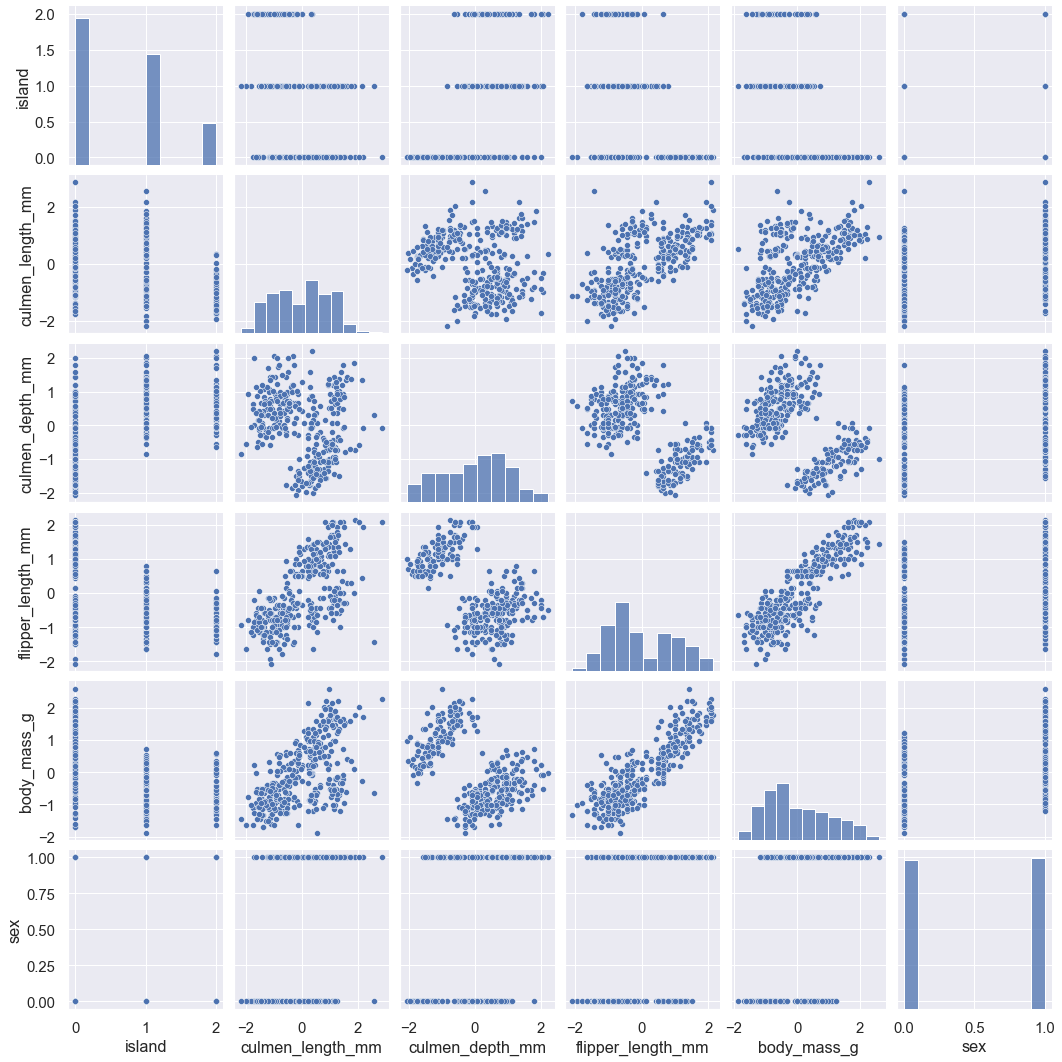

In [111]:
sns.pairplot(df)

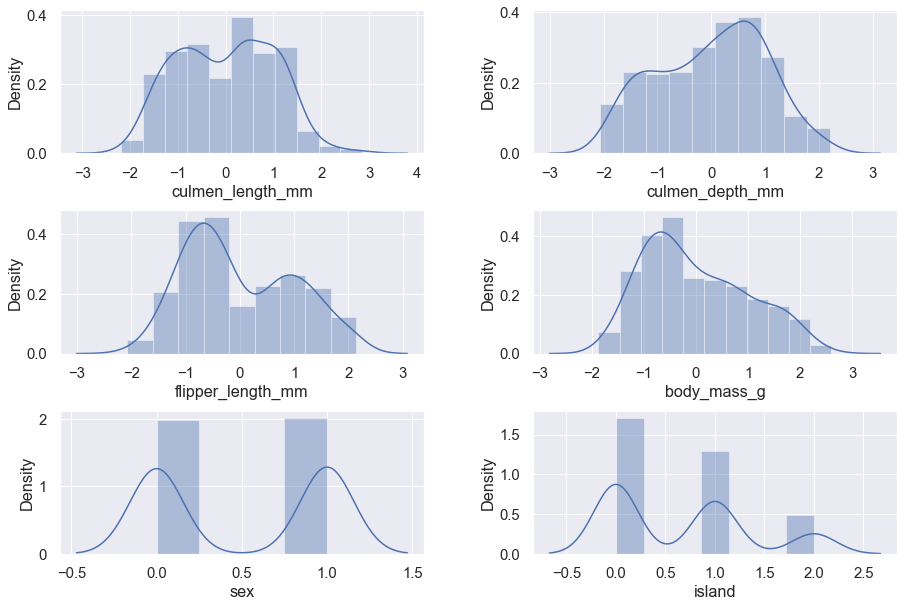

In [112]:
fig, ax2 = plt.subplots(3, 2, figsize=(15, 10))
sns.distplot(df['culmen_length_mm'],ax=ax2[0][0])
sns.distplot(df['culmen_depth_mm'],ax=ax2[0][1])
sns.distplot(df['flipper_length_mm'],ax=ax2[1][0])
sns.distplot(df['body_mass_g'],ax=ax2[1][1])
sns.distplot(df['sex'],ax=ax2[2][0])
sns.distplot(df['island'],ax=ax2[2][1])
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

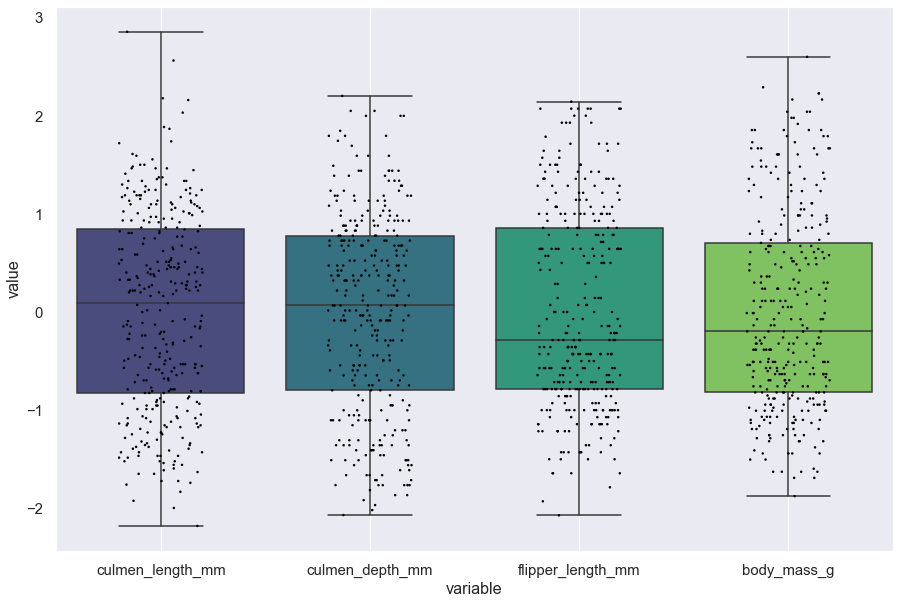

In [113]:
plt.figure(figsize=(15, 10))
sns.boxplot(x="variable", y="value", data=pd.melt(df[columns]), palette='viridis')
sns.stripplot(x="variable", y="value", data=pd.melt(df[columns]), color="black", jitter=0.2, size=2.5)
plt.grid()

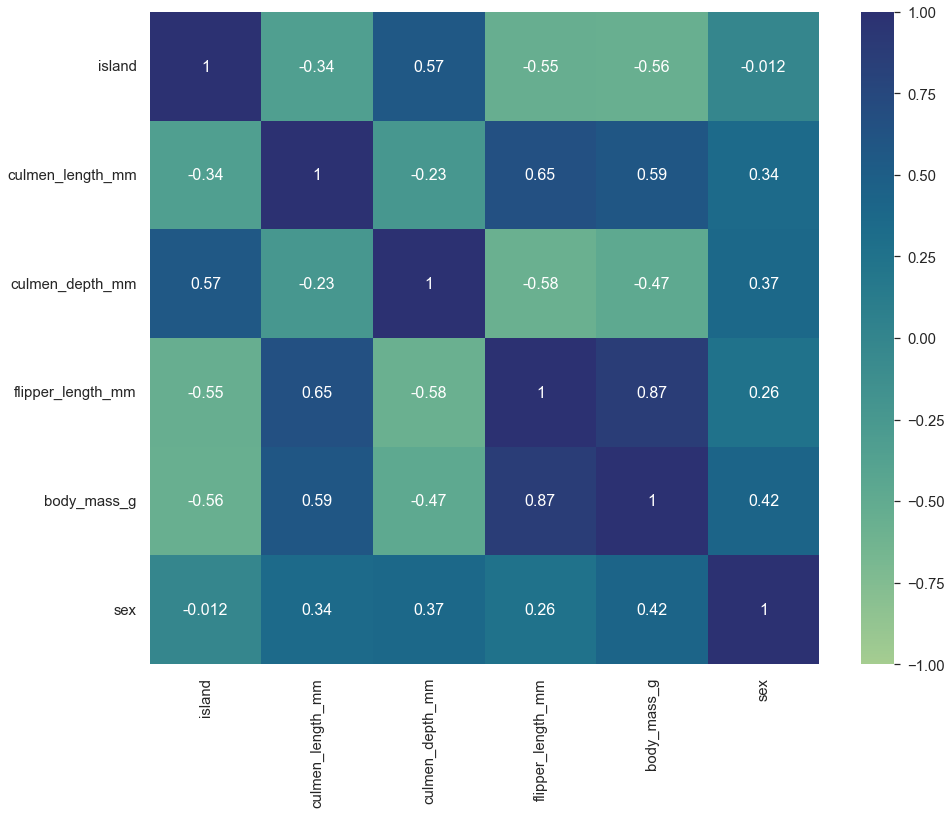

In [114]:
# Korrelationen
correlations = df.corr(method="pearson")
plt.figure(figsize=(15, 12))
sns.heatmap(correlations, vmin= -1, cmap="crest", annot=True, annot_kws={"fontsize":16})
plt.show()

#### KMeans

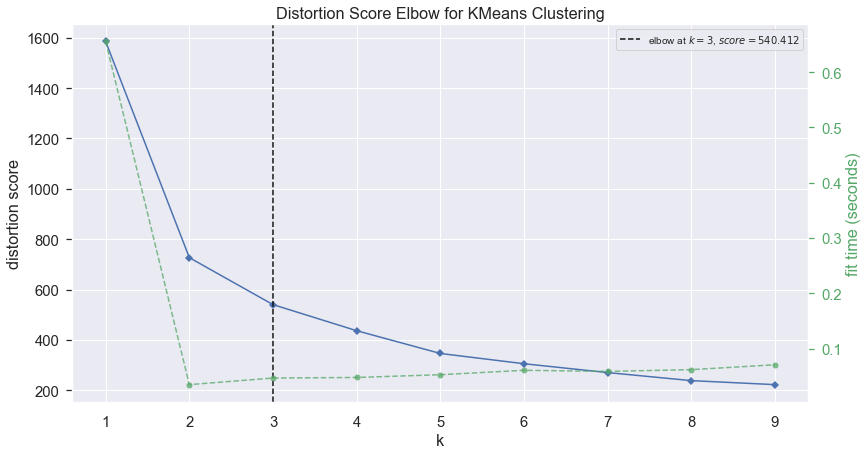

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [115]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10),size=(950, 500))
visualizer.fit(df)
visualizer.show()

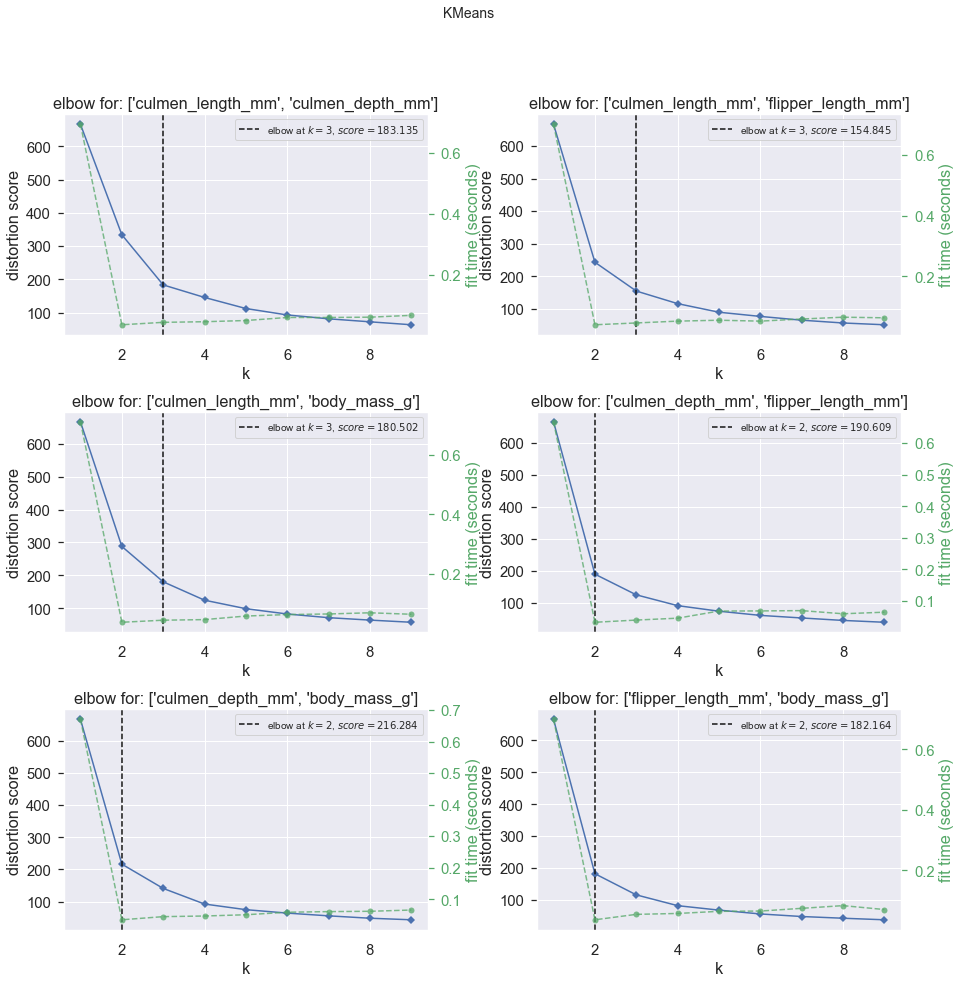

In [116]:
fig, axes = plt.subplots(3,2, figsize=(15, 15))
plt.suptitle("KMeans", fontsize=14)
model = KMeans()
columns = [["culmen_length_mm", "culmen_depth_mm"], ["culmen_length_mm", "flipper_length_mm"], ["culmen_length_mm", "body_mass_g"], ["culmen_depth_mm", "flipper_length_mm"], ["culmen_depth_mm", "body_mass_g"], ["flipper_length_mm", "body_mass_g"]]
i=0
y=0
for column in columns:
    viz = KElbowVisualizer(model, k=(1,10), ax=axes[i][y], title= "elbow for:" + " " + str(column))
    viz.fit(df[column])
    viz.finalize()
    y+=1
    if y == 2:
        y=0
        i+=1
    
    
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()

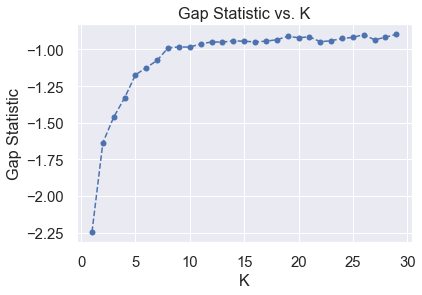

In [117]:
# Gap Statistic for K means
# src: https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
    # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
    # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
    # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
    # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
    # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)

score_g, df_gap = optimalK(df, nrefs=5, maxClusters=30)
plt.plot(df_gap['clusterCount'], df_gap['gap'], linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic vs. K')
plt.show()

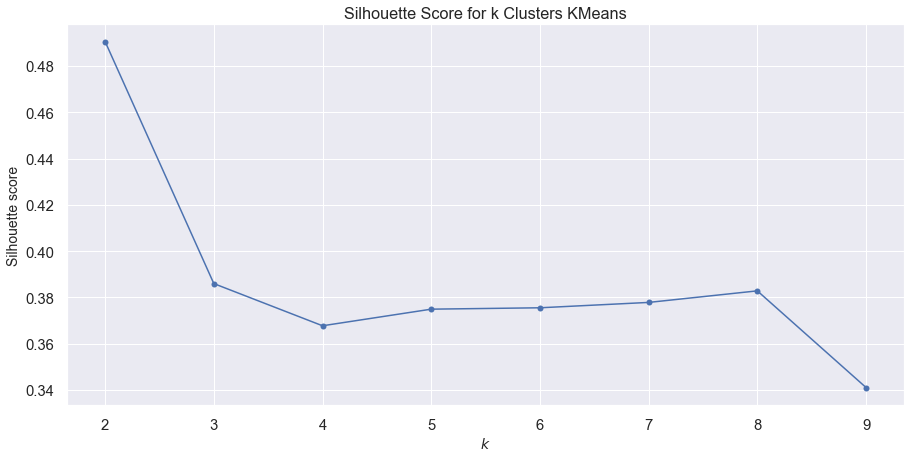

In [118]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

silhouette_scores = [silhouette_score(df, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(15, 7))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette Score for k Clusters KMeans")
plt.show()

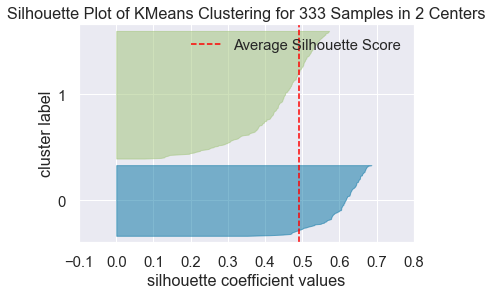

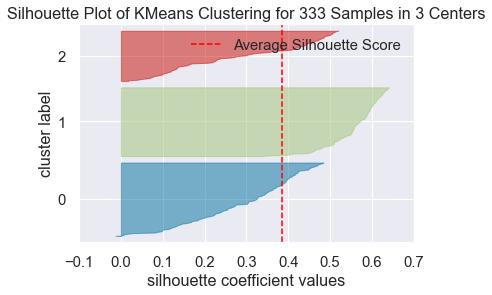

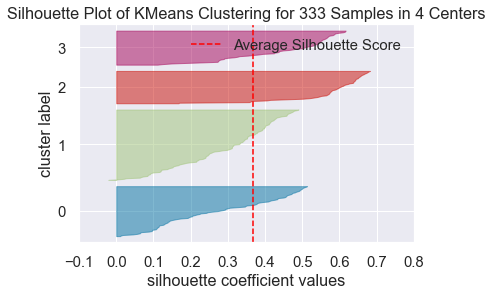

In [119]:
for i in range(2,5):
    silhouette_visualizer(KMeans(i, random_state=11), df, colors='yellowbrick')

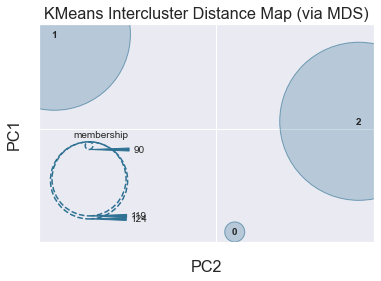

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [120]:
model = KMeans(3)  # Kmeans mit 3 Cluster
visualizer = InterclusterDistance(model)
visualizer.fit(df)
visualizer.show()

#### AgglomerativeClustering

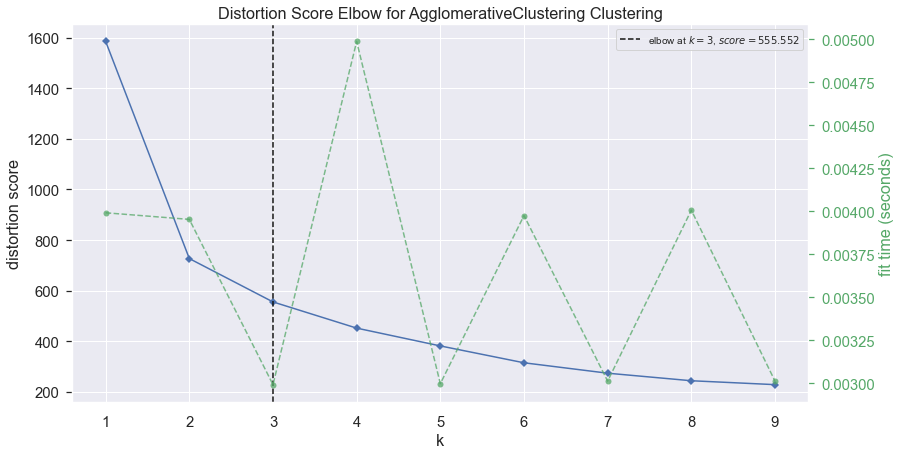

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [150]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(1,10),size=(950, 500))
visualizer.fit(df)
visualizer.show()

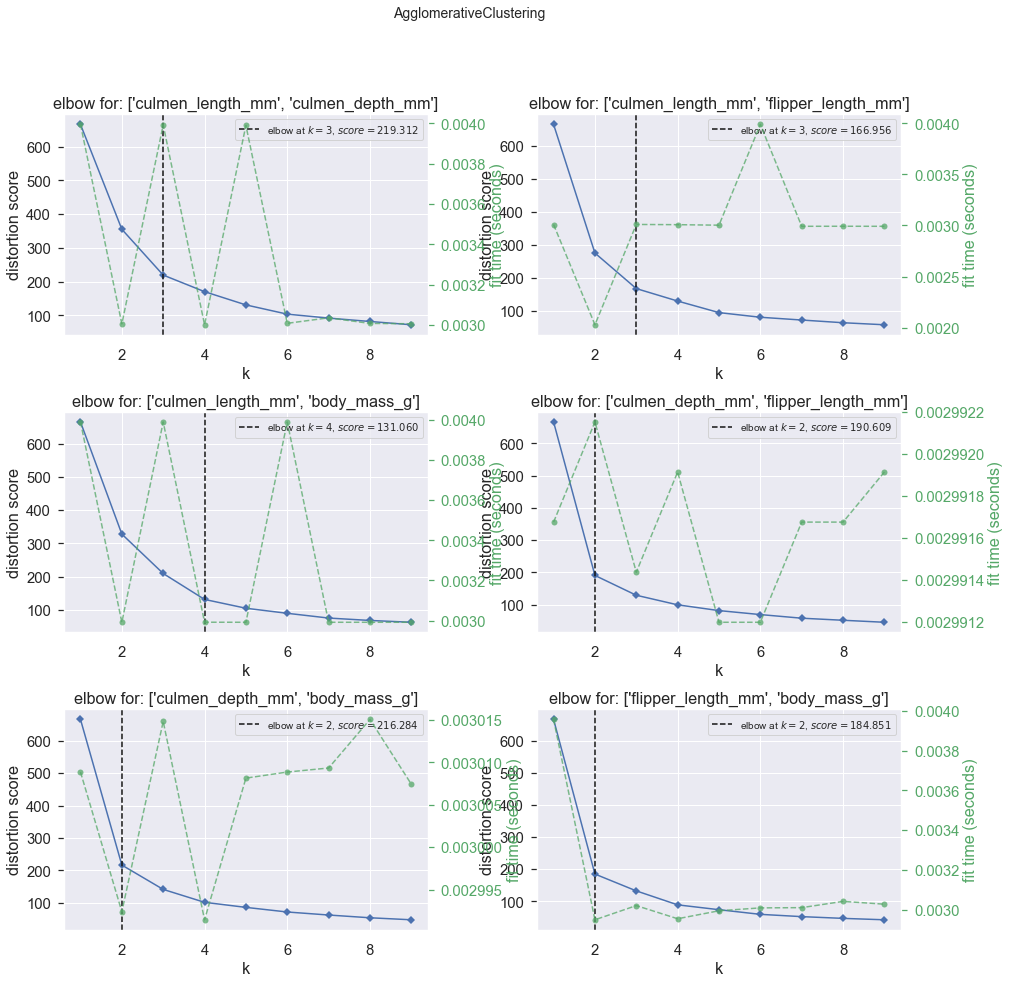

In [122]:
fig, axes = plt.subplots(3,2, figsize=(15, 15))
plt.suptitle("AgglomerativeClustering", fontsize=14)
model = AgglomerativeClustering()
columns = [["culmen_length_mm", "culmen_depth_mm"], ["culmen_length_mm", "flipper_length_mm"], ["culmen_length_mm", "body_mass_g"], ["culmen_depth_mm", "flipper_length_mm"], ["culmen_depth_mm", "body_mass_g"], ["flipper_length_mm", "body_mass_g"]]
i=0
y=0
for column in columns:
    viz = KElbowVisualizer(model, k=(1,10), ax=axes[i][y], title= "elbow for:" + " " + str(column))
    viz.fit(df[column])
    viz.finalize()
    y+=1
    if y == 2:
        y=0
        i+=1
    
    
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.show()

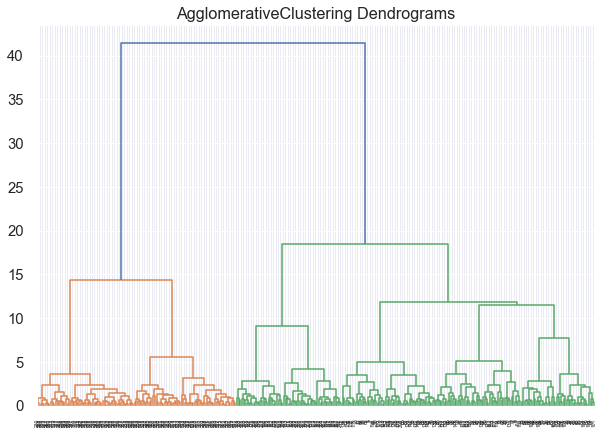

In [123]:
# Dendogram for Heirarchical Clustering
plt.figure(figsize=(10, 7))
plt.title("AgglomerativeClustering Dendrograms")  
dend = shc.dendrogram(shc.linkage(df, method='ward'))

#### Anzahl Cluster

> Aufgrund der vorherigen Analysen sollten 3 Cluster für KMeans sowie auch für Agglomerative Clustering gut passen. MeanShift braucht keine Angabe zur Anzahl Cluster.

### Dimensionen reduzieren

In [124]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(df)

In [125]:
# Anteil Varianz jeder Hauptkomponente
pca_array = pca.explained_variance_ratio_
print("2 Hauptkomponenten:", pca_array)
print("3. Komponente:", 1.0 - (pca_array[0] + pca_array[1]))

2 Hauptkomponenten: [0.62396605 0.19520597]
3. Komponente: 0.1808279754556592


In [126]:
pca = PCA(n_components=0.95)  # Mindestens 95 % Varianz abdecken
X_reduced = pca.fit_transform(df)
print(X_reduced[0])

[-2.11708909  0.45076805 -0.35030375 -0.63809372]


In [127]:
kmeans2d = KMeans(n_clusters=3, random_state=0).fit(X2D)
#print(kmeans2d.labels_)
#print(kmeans2d.cluster_centers_)
X2D_labels = []
for x in X2D:
    X2D_labels.append(kmeans2d.predict([x])[0])
print(X2D_labels)

[2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Machine Learning

In [128]:
# For Example predicts on models
df_list = df.values.tolist()
print(df_list[0])

[2.0, -0.8960418897725922, 0.7807321043966328, -1.4267515672137063, -0.5684747832140795, 1.0]


#### KMeans

In [129]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df)

KMeans(n_clusters=3, random_state=42)

In [130]:
kmeans.predict([df_list[0]])


array([0])

In [131]:
kmeans.get_params(deep=True)

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 3,
 'n_init': 10,
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

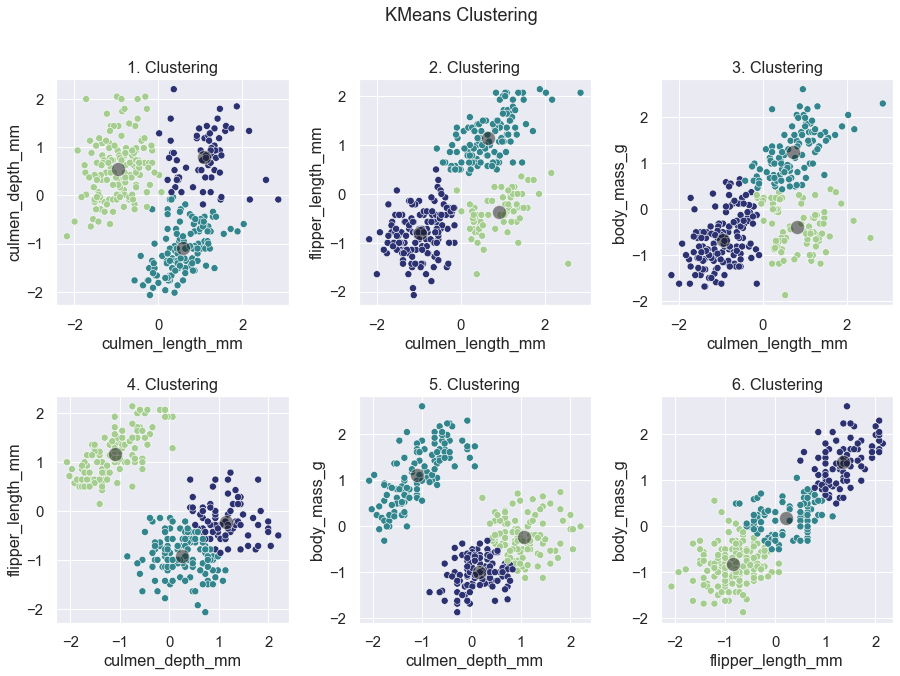

In [132]:
i = 1
dfkmean = df.copy()
kmean_clusters = [["culmen_length_mm", "culmen_depth_mm"], ["culmen_length_mm", "flipper_length_mm"], ["culmen_length_mm", "body_mass_g"], ["culmen_depth_mm", "flipper_length_mm"], ["culmen_depth_mm", "body_mass_g"], ["flipper_length_mm", "body_mass_g"]]

plt.figure(figsize=(15, 10))
plt.suptitle("KMeans Clustering", fontsize=18)

for cluster in kmean_clusters:
    X_kmean = dfkmean[cluster]
    kmeans = KMeans(n_clusters=3, random_state=14)
    kmeans.fit(X_kmean)
    y_kmeans = kmeans.predict(X_kmean)
    dfkmean[f"Cluster{i}"] = y_kmeans
    plt.subplot(2, 3, i)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.title(f"{i}. Clustering")
    sns.scatterplot(X_kmean.loc[:, cluster[0]], X_kmean.loc[:, cluster[1]], c=y_kmeans, s=50, cmap="crest")
    centers = kmeans.cluster_centers_
    sns.scatterplot(centers[:, 0], centers[:, 1], s=200, color="k", alpha=0.5)
    i+=1
plt.show()

#### MeanShift

In [133]:
ms = MeanShift(bandwidth=None)
ms.fit(df)

MeanShift()

In [134]:
ms.predict([df_list[0]])

array([0], dtype=int64)

In [135]:
ms.get_params(deep=True)

{'bandwidth': None,
 'bin_seeding': False,
 'cluster_all': True,
 'max_iter': 300,
 'min_bin_freq': 1,
 'n_jobs': None,
 'seeds': None}

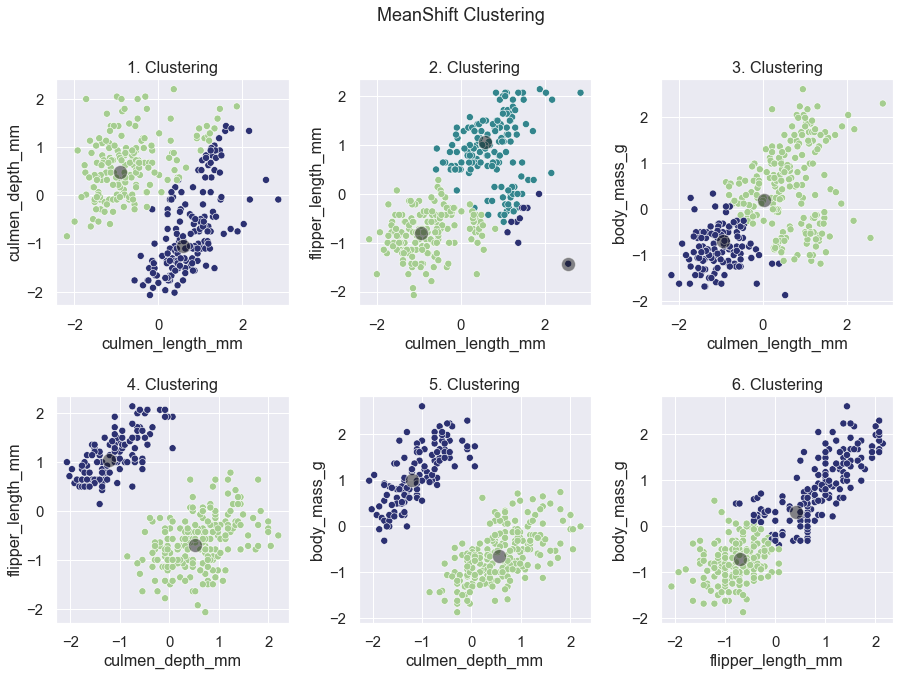

In [136]:
i = 1
dfmeanshift = df.copy()
meanshift_clusters = [["culmen_length_mm", "culmen_depth_mm"], ["culmen_length_mm", "flipper_length_mm"], ["culmen_length_mm", "body_mass_g"], ["culmen_depth_mm", "flipper_length_mm"], ["culmen_depth_mm", "body_mass_g"], ["flipper_length_mm", "body_mass_g"]]

plt.figure(figsize=(15, 10))
plt.suptitle("MeanShift Clustering", fontsize=18)

for cluster in meanshift_clusters:
    X_meanshift = dfmeanshift[cluster]
    bandwidth = estimate_bandwidth(X_meanshift)
    meanshift = MeanShift(bandwidth=bandwidth)
    meanshift.fit(X_meanshift)
    y_meanshift = meanshift.predict(X_meanshift)
    dfmeanshift[f"Cluster{i}"] = y_meanshift
    plt.subplot(2, 3, i)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.title(f"{i}. Clustering")
    sns.scatterplot(X_meanshift.loc[:, cluster[0]], X_meanshift.loc[:, cluster[1]], c=y_meanshift, s=50, cmap="crest")
    centers = meanshift.cluster_centers_
    sns.scatterplot(centers[:, 0], centers[:, 1], s=200, color="k", alpha=0.5)
    i+=1
plt.show()

#### AgglomerativeClustering

In [137]:
agg = AgglomerativeClustering(n_clusters=3)
agg.fit_predict(df)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [138]:
agg.get_params(deep=True)

{'affinity': 'euclidean',
 'compute_distances': False,
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': None,
 'linkage': 'ward',
 'memory': None,
 'n_clusters': 3}

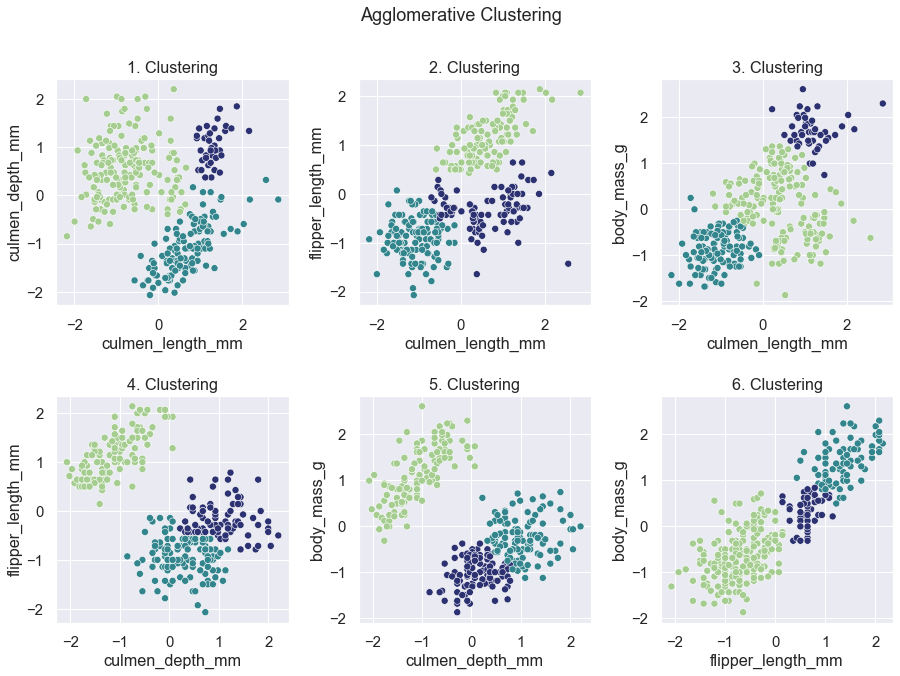

In [139]:
i = 1
dfagg = df.copy()
agg_clusters = [["culmen_length_mm", "culmen_depth_mm"], ["culmen_length_mm", "flipper_length_mm"], ["culmen_length_mm", "body_mass_g"], ["culmen_depth_mm", "flipper_length_mm"], ["culmen_depth_mm", "body_mass_g"], ["flipper_length_mm", "body_mass_g"]]

plt.figure(figsize=(15, 10))
plt.suptitle("Agglomerative Clustering", fontsize=18)

for cluster in agg_clusters:
    X_agg = dfagg[cluster]
    agg = AgglomerativeClustering(n_clusters=3)
    y_agg = agg.fit_predict(X_agg)
    dfagg[f"Cluster{i}"] = y_agg
    plt.subplot(2, 3, i)
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    plt.title(f"{i}. Clustering")
    sns.scatterplot(X_agg.loc[:, cluster[0]], X_agg.loc[:, cluster[1]], c=y_agg, s=50, cmap="crest")
    i+=1
plt.show()

### Evaluieren

> Anhand von diesen Violinplots kann die Verteilung und Dichte der Daten der jeweiligen Modelle analyisiert werden. Auf der X-Achse befinden sich die Index zu den jeweiligen vorhergesagten Cluster.

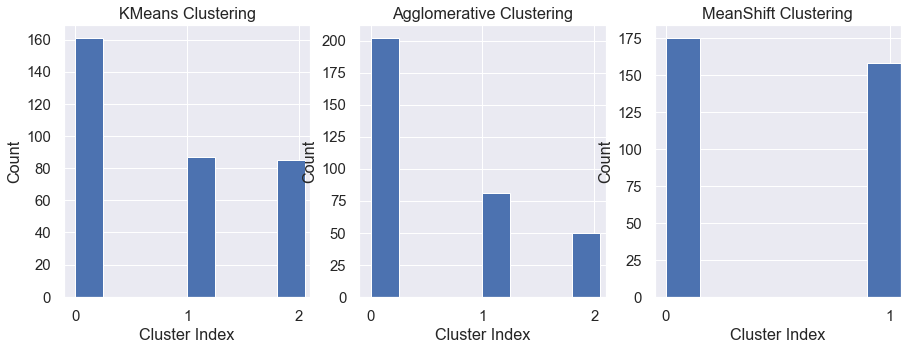

In [140]:
kmeanslabels = list(kmeans.labels_)
agglomerativelabels = list(agg.labels_)
meanshiftlabels = list(meanshift.labels_)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("KMeans Clustering")
plt.hist(kmeans.labels_, width=0.25)
plt.xticks(np.arange(min(kmeanslabels), max(kmeanslabels)+1, 1.0))
plt.xlabel("Cluster Index")
plt.ylabel("Count")

plt.subplot(1, 3, 2)
plt.title("Agglomerative Clustering")
plt.hist(agg.labels_, width=0.25)
plt.xticks(np.arange(min(agglomerativelabels), max(agglomerativelabels)+1, 1.0))
plt.xlabel("Cluster Index")
plt.ylabel("Count")

plt.subplot(1, 3, 3)
plt.title("MeanShift Clustering")
plt.hist(meanshift.labels_, width=0.15)
plt.xticks(np.arange(min(meanshiftlabels), max(meanshiftlabels)+1, 1.0))
plt.xlabel("Cluster Index")
plt.ylabel("Count")

plt.show()

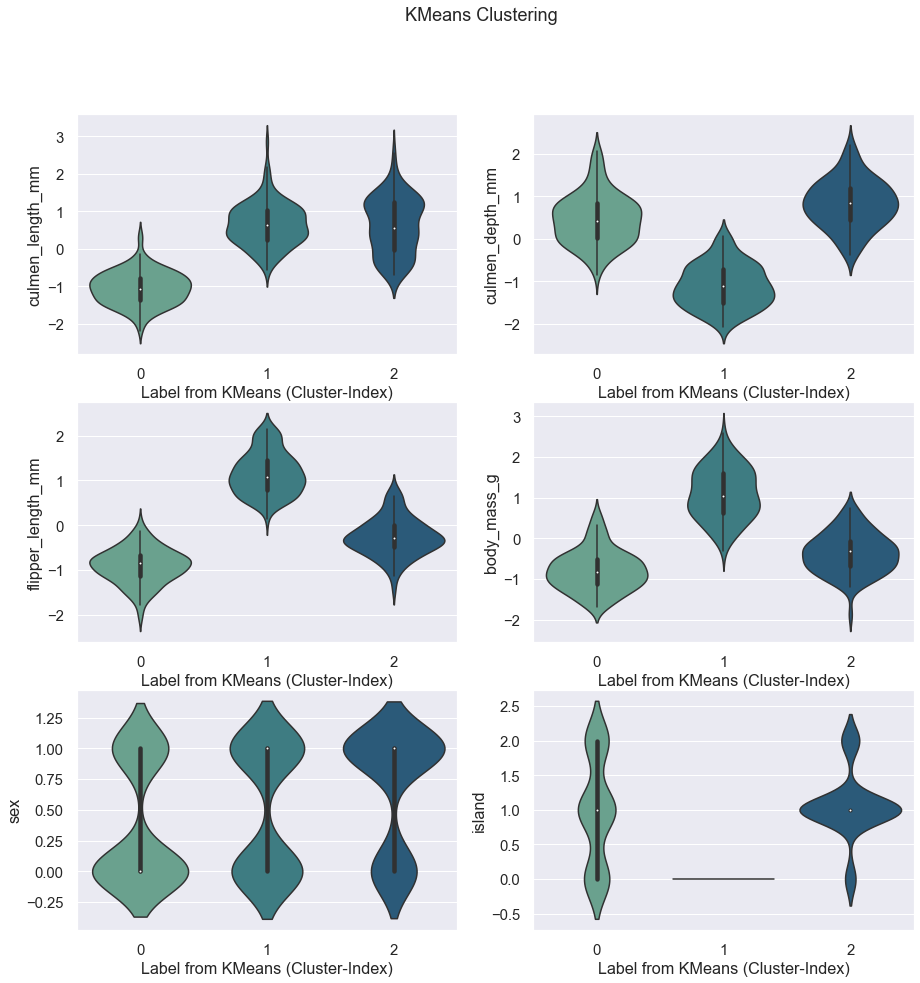

In [141]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df)

plt.figure(figsize=(15, 15))
plt.suptitle("KMeans Clustering", fontsize=18)
i=1
columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'island']
for col in columns:
    plt.subplot(3, 2, i)
    fig = sns.violinplot(x=kmeans.labels_, y=df[col], palette='crest')
    fig.set_xlabel("Label from KMeans (Cluster-Index)")
    i+=1
plt.show()

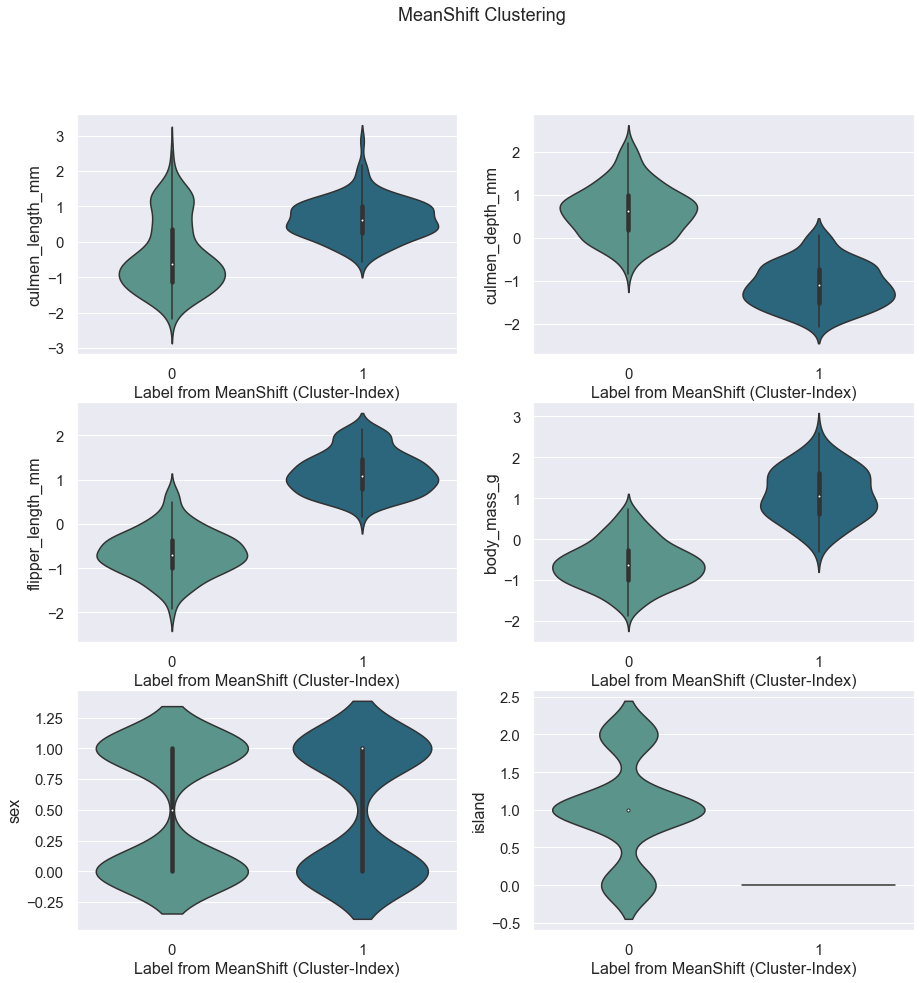

In [142]:
bandwidth = estimate_bandwidth(df)
meanshift = MeanShift(bandwidth=bandwidth)
meanshift.fit(df)

plt.figure(figsize=(15, 15))
plt.suptitle("MeanShift Clustering", fontsize=18)
i=1
columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'island']
for col in columns:
    plt.subplot(3, 2, i)
    fig = sns.violinplot(x=meanshift.labels_, y=df[col], palette='crest')
    fig.set_xlabel("Label from MeanShift (Cluster-Index)")
    i+=1
plt.show()

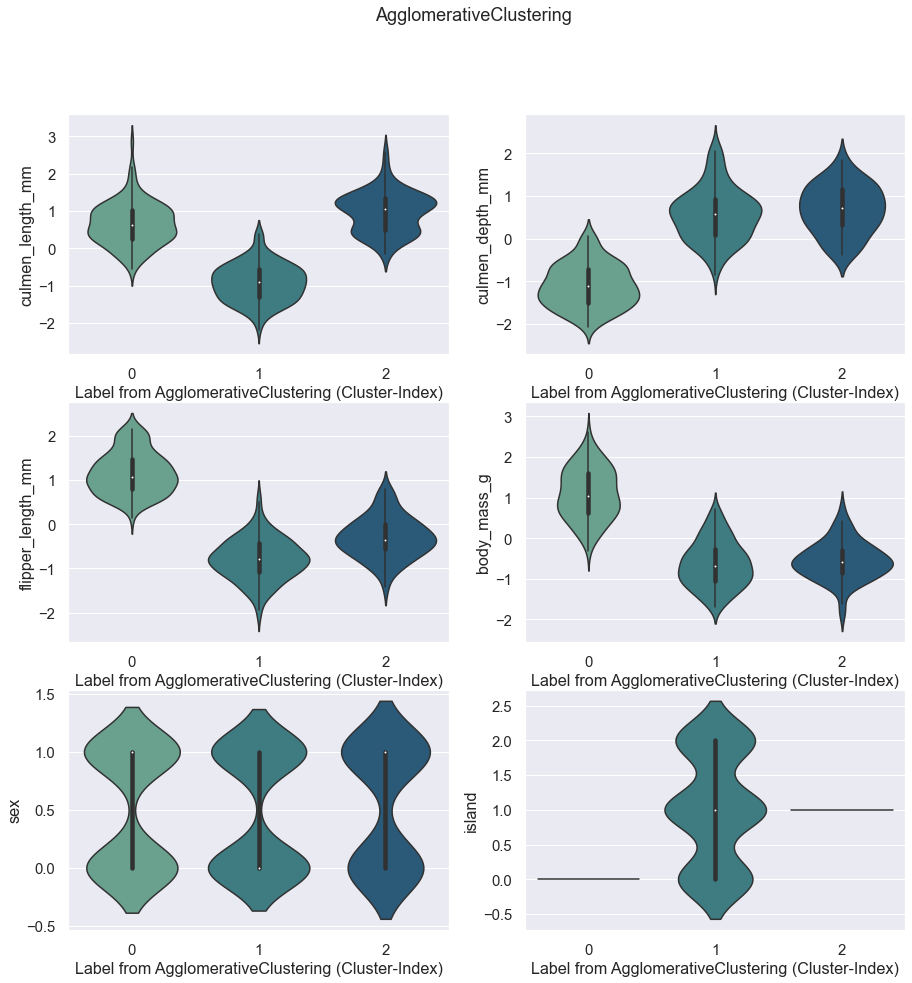

In [143]:
k = 3
agg = AgglomerativeClustering(n_clusters=k)
agg.fit(df)

plt.figure(figsize=(15, 15))
plt.suptitle("AgglomerativeClustering", fontsize=18)
i=1
columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'island']
for col in columns:
    plt.subplot(3, 2, i)
    fig = sns.violinplot(x=agg.labels_, y=df[col], palette='crest')
    fig.set_xlabel("Label from AgglomerativeClustering (Cluster-Index)")
    i+=1
plt.show()